<h1><center>Restaurant Revenue Prediction</center></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
from sklearn.cross_decomposition import PLSRegression

In [2]:
df=pd.read_csv('data/train.csv',index_col='Id')
df.columns=[s.replace(' ','_') for s in df.columns]
df['Open_Date']=pd.to_datetime(df['Open_Date'])
df_test=pd.read_csv('data/test.csv',index_col='Id')
df_test.columns=[s.replace(' ','_') for s in df_test.columns]
df_test['Open_Date']=pd.to_datetime(df_test['Open_Date'])
df.head()

,Open_Date,City,City_Group,Type,P1,P2,P3,P4,P5,P6,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
Id,,,,,,,,,,,,,,,,,,,,,
0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 136
Data columns (total 42 columns):
Open_Date     137 non-null datetime64[ns]
City          137 non-null object
City_Group    137 non-null object
Type          137 non-null object
P1            137 non-null int64
P2            137 non-null float64
P3            137 non-null float64
P4            137 non-null float64
P5            137 non-null int64
P6            137 non-null int64
P7            137 non-null int64
P8            137 non-null int64
P9            137 non-null int64
P10           137 non-null int64
P11           137 non-null int64
P12           137 non-null int64
P13           137 non-null float64
P14           137 non-null int64
P15           137 non-null int64
P16           137 non-null int64
P17           137 non-null int64
P18           137 non-null int64
P19           137 non-null int64
P20           137 non-null int64
P21           137 non-null int64
P22           137 non-null int64
P23           137

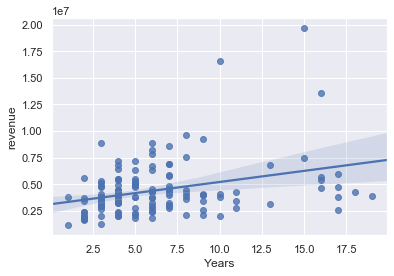

In [4]:
# Years column contain number of years for which the restaurant has been running
df['Years']=2015-df.Open_Date.dt.year
df_test['Years']=2015-df_test.Open_Date.dt.year
sns.set()
sns.regplot(x='Years',y='revenue',data=df);

Average revenue of older restaurants is slightly more than the newer restaurants.

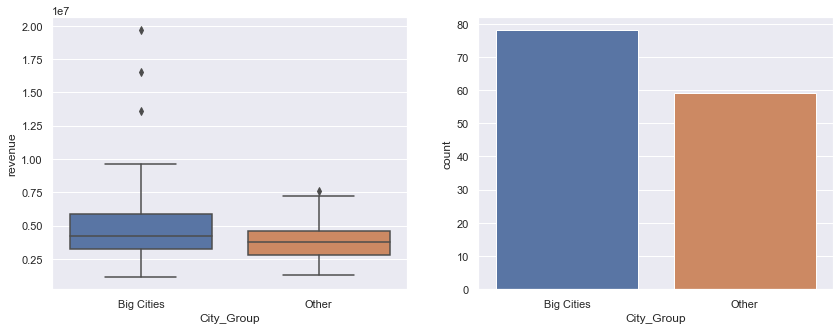

In [5]:
_,axes=plt.subplots(1,2,figsize=(14,5))
sns.set()
sns.boxplot(x='City_Group',y='revenue',data=df,ax=axes[0])
sns.countplot(x='City_Group',data=df,ax=axes[1]);

Median revenue of restaurants in big cities is higher than other cities

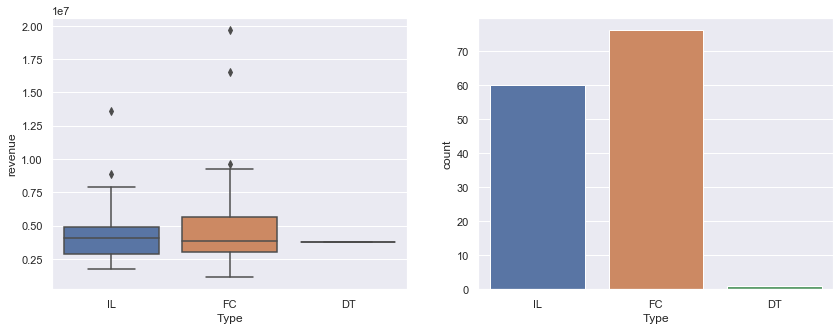

In [6]:
_,axes=plt.subplots(1,2,figsize=(14,5))
sns.set()
sns.boxplot(x='Type',y='revenue',data=df,ax=axes[0])
sns.countplot(x='Type',data=df,ax=axes[1]);

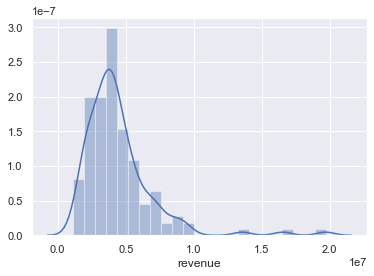

In [7]:
sns.set()
sns.distplot(df['revenue']);

Disrtibution of y is skewed

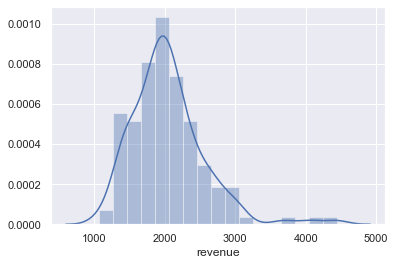

In [8]:
sns.set()
sns.distplot(np.sqrt(df['revenue']));

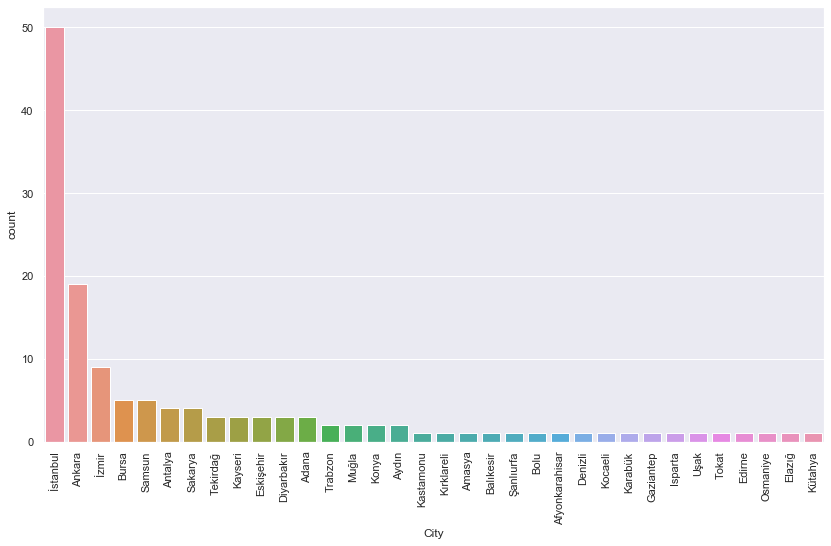

In [9]:
plt.figure(figsize=(14,8))
sns.countplot(x='City',data=df,order = df['City'].value_counts().index,orient="h")
plt.xticks(rotation=90);

In [10]:
 df['City'].value_counts()

İstanbul          50
Ankara            19
İzmir              9
Bursa              5
Samsun             5
Antalya            4
Sakarya            4
Tekirdağ           3
Kayseri            3
Eskişehir          3
Diyarbakır         3
Adana              3
Trabzon            2
Muğla              2
Konya              2
Aydın              2
Kastamonu          1
Kırklareli         1
Amasya             1
Balıkesir          1
Şanlıurfa          1
Bolu               1
Afyonkarahisar     1
Denizli            1
Kocaeli            1
Karabük            1
Gaziantep          1
Isparta            1
Uşak               1
Tokat              1
Edirne             1
Osmaniye           1
Elazığ             1
Kütahya            1
Name: City, dtype: int64

In [11]:
 df_test['City'].value_counts()

İstanbul          34087
Ankara             8720
İzmir              6465
Antalya            5911
Kocaeli            4364
Mersin             2735
Adana              2514
Balıkesir          2463
Bursa              2441
Muğla              1823
Aydın              1617
Tekirdağ           1577
Konya              1576
Gaziantep          1487
Edirne             1230
Manisa             1227
Çanakkale           965
Denizli             964
Diyarbakır          954
Hatay               951
Zonguldak           926
Eskişehir           900
Trabzon             660
Aksaray             650
Bolu                631
Yalova              630
Kırıkkale           622
Malatya             616
Mardin              610
Şanlıurfa           609
Sakarya             604
Batman              604
Rize                345
Artvin              344
Bilecik             339
Afyonkarahisar      331
Nevşehir            328
Sivas               326
Samsun              324
Kayseri             323
Kırşehir            319
Erzincan        

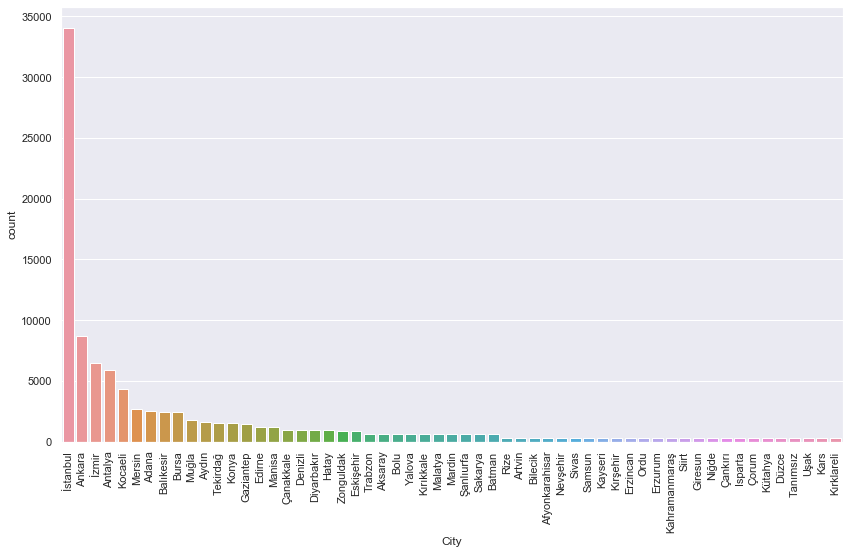

In [12]:
plt.figure(figsize=(14,8))
sns.countplot(x='City',data=df_test,order = df_test['City'].value_counts().index)
plt.xticks(rotation=90);

Training data has very few restaurants in most of the countries which are present in test data in large numbers. These countries can be grouped as 'other' countries.

In [13]:
# Classifying countries other than the top 5 as others
common_city_list=['İstanbul','Ankara','İzmir','Bursa','Antalya']
df['City']=df['City'].apply(lambda x: x if x in common_city_list else 'Other')
df_test['City']=df_test['City'].apply(lambda x: x if x in common_city_list else 'Other')

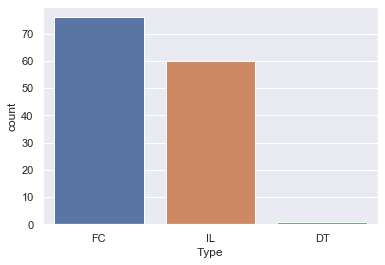

In [14]:
sns.countplot(x='Type',data=df,order = df['Type'].value_counts().index);

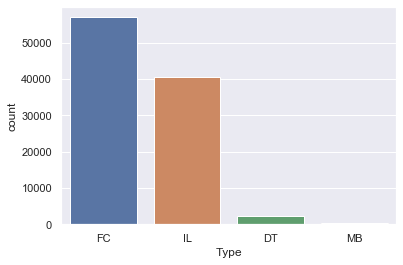

In [15]:
sns.countplot(x='Type',data=df_test,order = df_test['Type'].value_counts().index);

Restaurant types DT has very few occurances and resaturant type MB is not present in train data.
These two can be grouped as 'other' type

In [16]:
# Grouping restaurant type DT and MB as 'other'
df['Type']=df['Type'].apply(lambda x: x if x in ['FC','IL'] else 'Other')
df_test['Type']=df_test['Type'].apply(lambda x: x if x in ['FC','IL'] else 'Other')

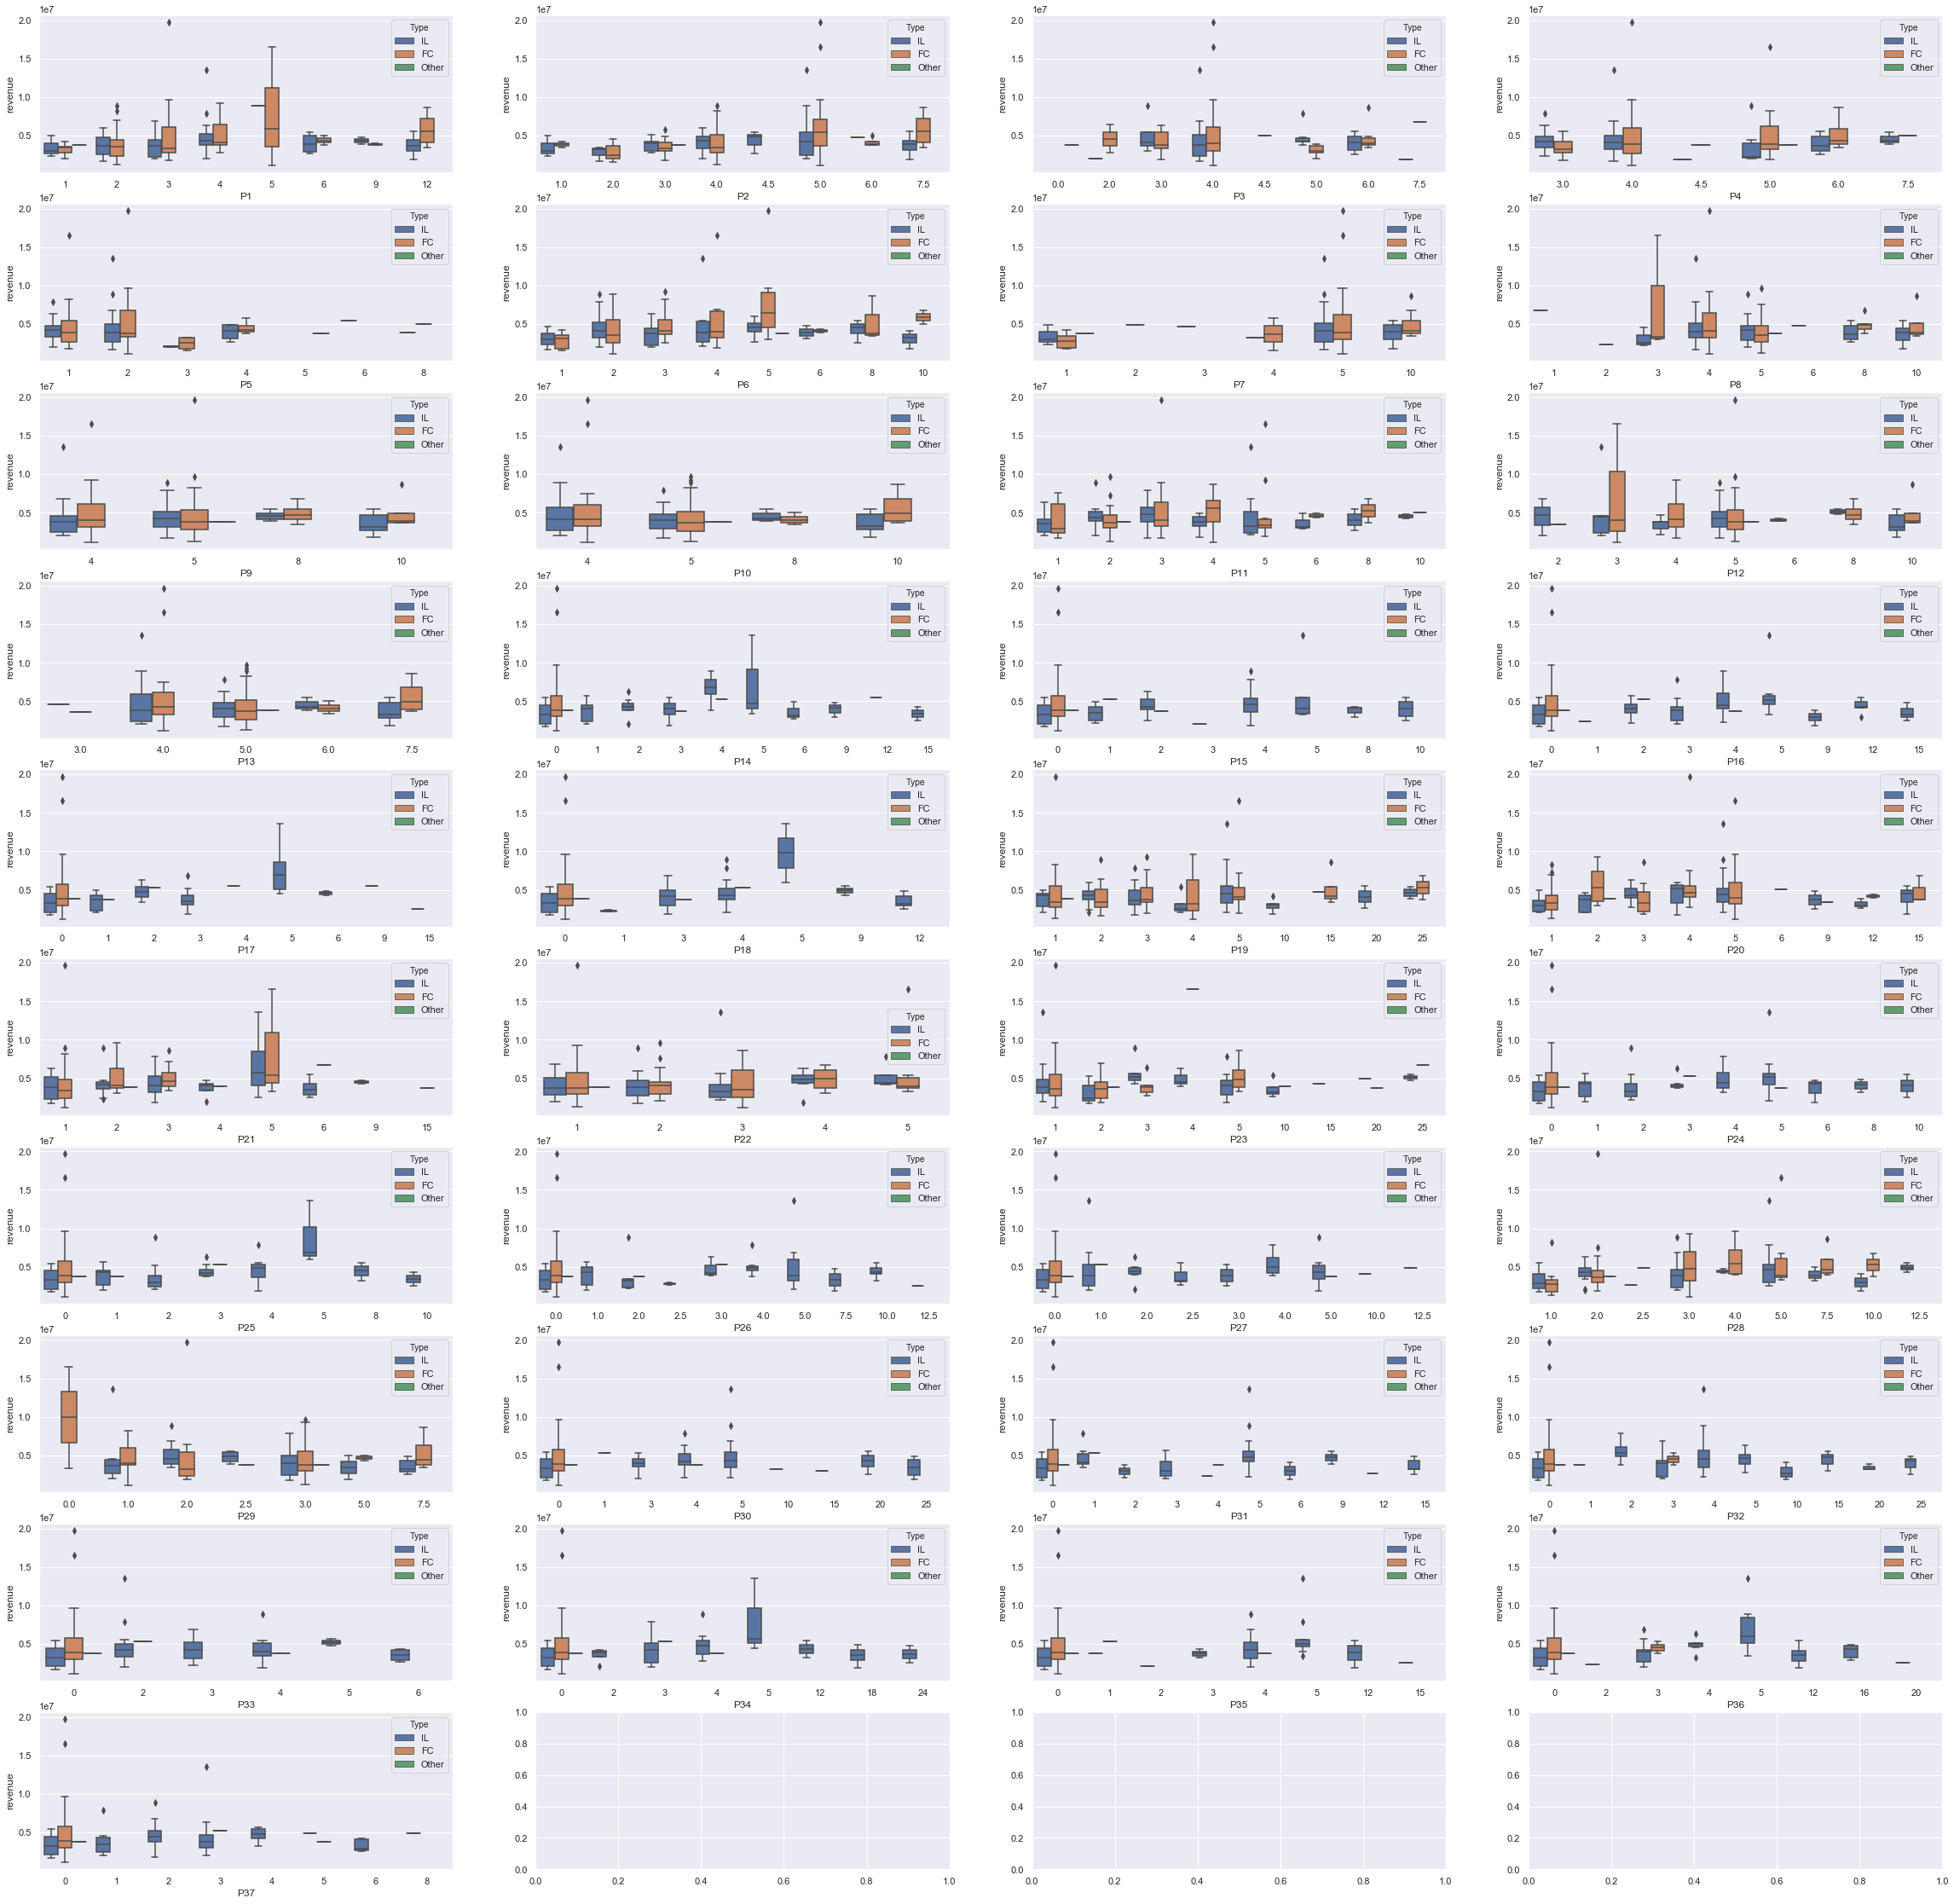

In [17]:
_,axes=plt.subplots(10,4,figsize=(40,40))
axes=axes.flatten()
sns.set()
for i in range(37):
    sns.boxplot(x=df['P'+str(i+1)],y='revenue',data=df,ax=axes[i],hue='Type')

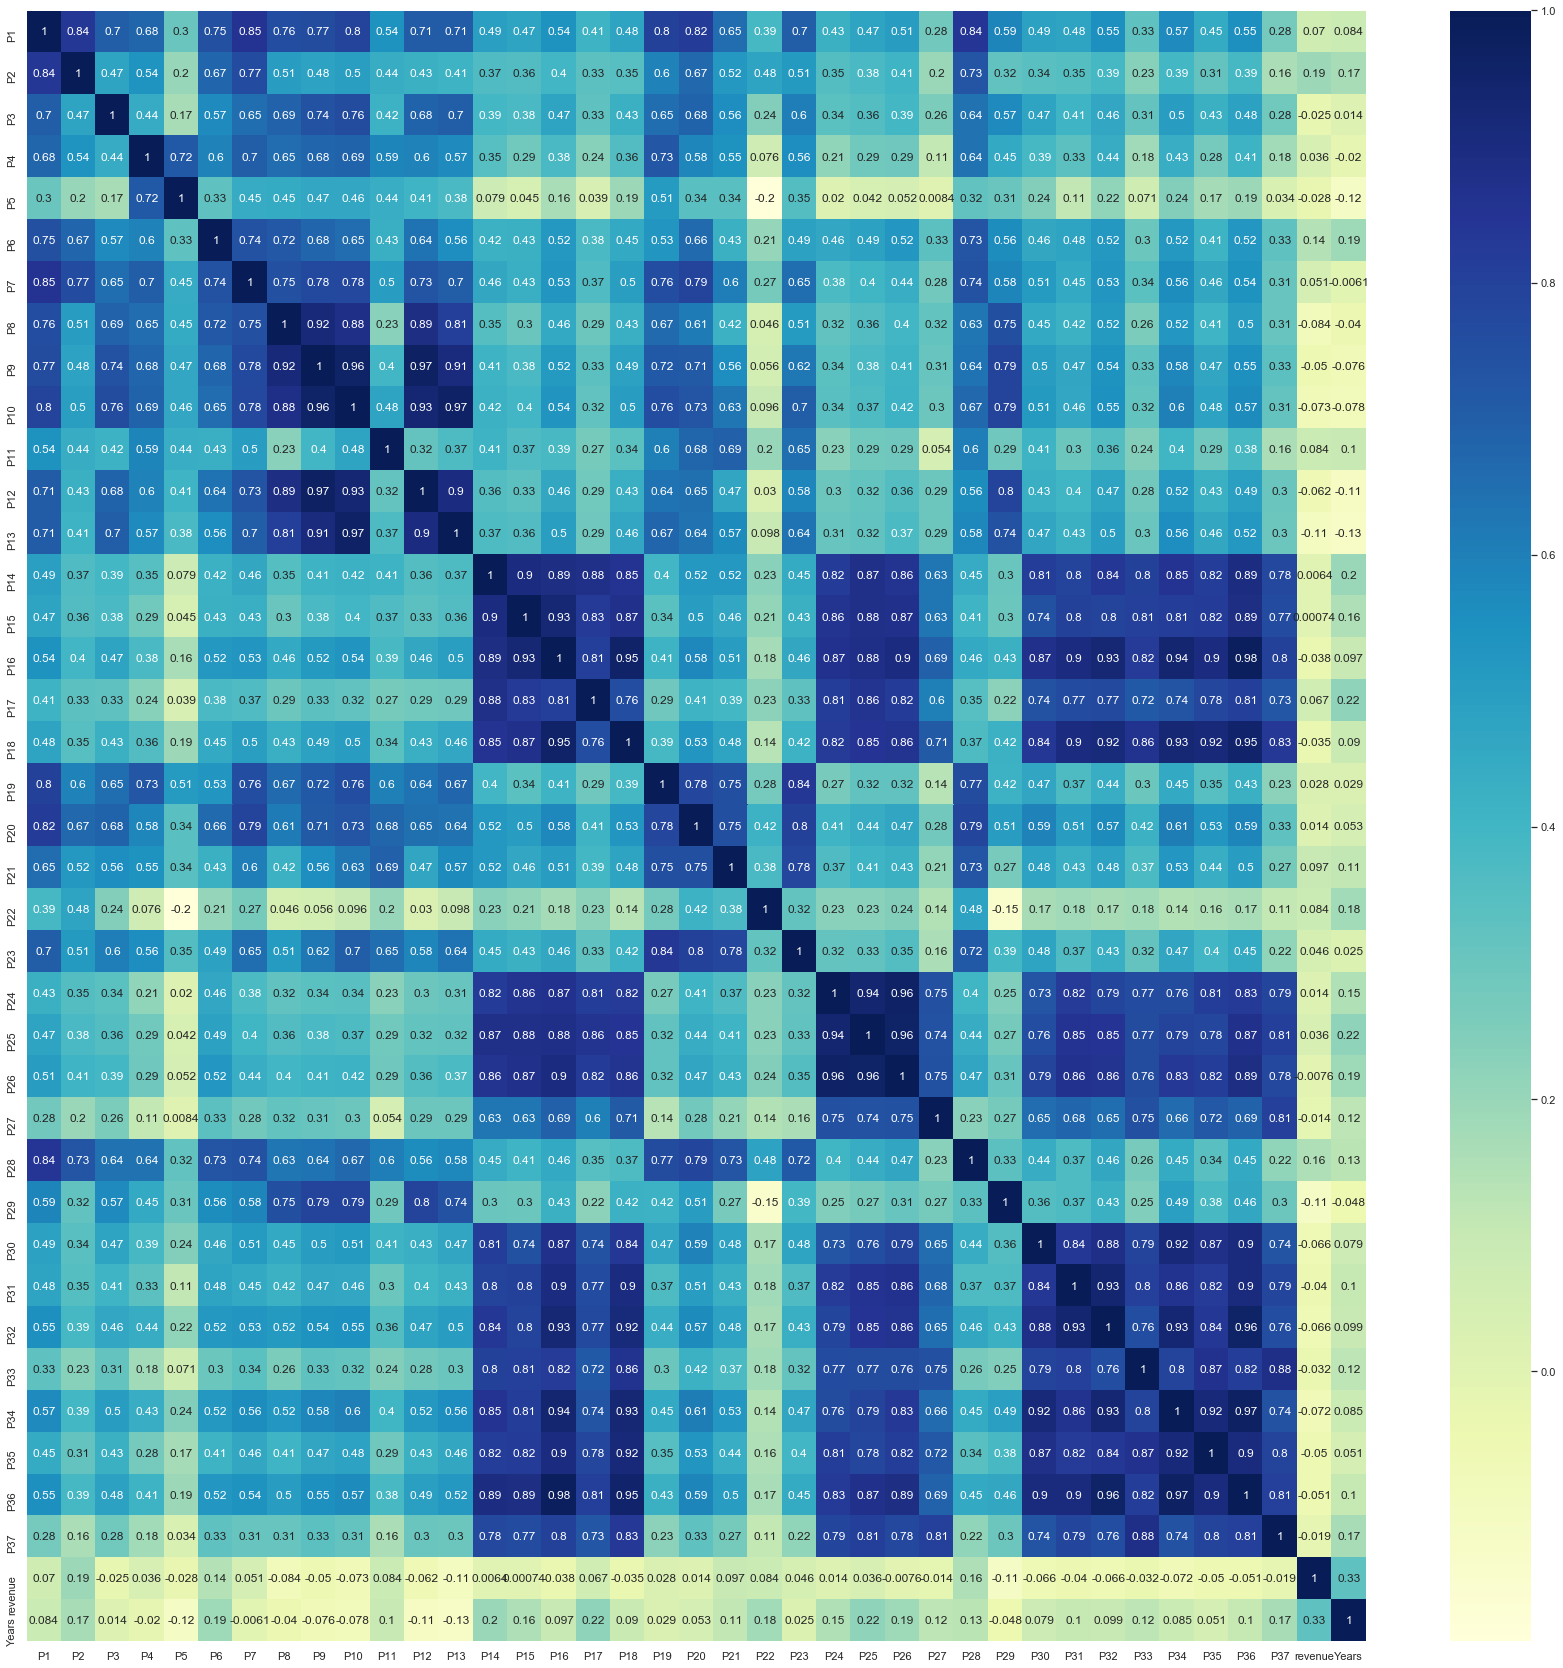

In [18]:
# Correlation heatmap
sns.set()
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu");

In [19]:
# Standardizing numerical features
df_num=df.drop(['revenue','City','City_Group','Type','Open_Date'],axis=1)
scaler = StandardScaler()
df_num_scaled=pd.DataFrame(scaler.fit_transform(df_num),columns=df_num.columns)

In [20]:
# Checking for multicollinearity using variance inflation factor(VIF) 
pd.Series([variance_inflation_factor(df_num_scaled.values, i) for i in range(df_num_scaled.shape[1])], index=df_num_scaled.columns)

P1        22.941273
P2         7.249908
P3         3.944060
P4         6.563628
P5         4.467839
P6         5.799708
P7         7.645794
P8        21.539646
P9        79.367353
P10      193.158998
P11        6.839388
P12       36.017200
P13       54.480683
P14       19.766865
P15       31.031441
P16       81.697122
P17       11.929248
P18       40.252444
P19       14.502467
P20        9.769266
P21        6.061823
P22        2.449359
P23        7.841145
P24       34.312792
P25       28.942032
P26       52.955234
P27        4.644665
P28       10.653790
P29        7.252856
P30       18.940946
P31       19.544507
P32       41.402854
P33       11.768231
P34       84.968846
P35       32.849495
P36      187.231205
P37       11.424239
Years      1.566319
dtype: float64

From the correlation map anf vif values we can see that most of the variables are highly correlated.

In [21]:
# Removing features having  VIF greater then 5
drop_list=[]
df_num_uncorr=df_num_scaled.drop(drop_list,axis=1)
vif_series=pd.Series([variance_inflation_factor(df_num_uncorr.values, i) for i in range(df_num_uncorr.shape[1])], index=df_num_uncorr.columns)
while(vif_series.max()>5):
    drop_list.append(vif_series.idxmax())
    df_num_uncorr=df_num_scaled.drop(drop_list,axis=1)
    vif_series=pd.Series([variance_inflation_factor(df_num_uncorr.values, i) for i in range(df_num_uncorr.shape[1])], index=df_num_uncorr.columns)
df_num_uncorr=df_num.drop(drop_list,axis=1)
vif_series

P2       2.718301
P3       2.620075
P4       3.837329
P5       2.671301
P6       3.033769
P11      2.713556
P13      4.721233
P17      2.766245
P21      4.081097
P22      1.901705
P23      3.453282
P27      2.785911
P29      3.308978
P30      4.450805
P33      4.040684
Years    1.243825
dtype: float64

11 numerical features are left after removing correlated variables.

In [22]:
#One hot encoding categorical variables
df_cat=pd.get_dummies(df[['City','Type','City_Group']])
df_cat.drop('City_Group_Other',axis=1,inplace=True)
y=np.sqrt(df['revenue'])
# Concatenating numerical and categorical variables
x=pd.concat([df_num,df_cat],axis=1)
x.reset_index(drop=True,inplace=True)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 48 columns):
P1                       137 non-null int64
P2                       137 non-null float64
P3                       137 non-null float64
P4                       137 non-null float64
P5                       137 non-null int64
P6                       137 non-null int64
P7                       137 non-null int64
P8                       137 non-null int64
P9                       137 non-null int64
P10                      137 non-null int64
P11                      137 non-null int64
P12                      137 non-null int64
P13                      137 non-null float64
P14                      137 non-null int64
P15                      137 non-null int64
P16                      137 non-null int64
P17                      137 non-null int64
P18                      137 non-null int64
P19                      137 non-null int64
P20                      137 non-null int64
P21    

In [23]:
# Splitting data into train and test set in the ratio 70:30
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

Text(0, 0.5, 'Variance explained')

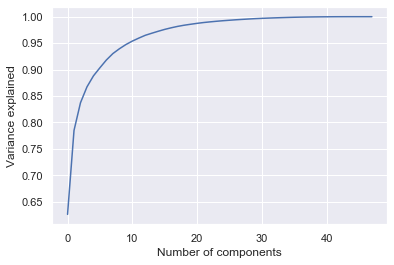

In [24]:
plt.plot(np.cumsum(PCA().fit(x).explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance explained')

In [25]:
# Dimensionality reduction using PCA
"""
pca=PCA(n_components=17)
x_train=pca.fit_transform(x_train)
x_test=pca.transform(x_test)
"""

'\npca=PCA(n_components=17)\nx_train=pca.fit_transform(x_train)\nx_test=pca.transform(x_test)\n'

In [26]:
# Dimensionality reduction using PLS
pls=PLSRegression(n_components=14)
x_train=pls.fit_transform(x_train,y_train)[0]
x_test=pls.transform(x_test)

In [27]:
results=[]

# Function to print and store scores
def print_result(name,reg):
    y_true_train=np.square(y_train)
    y_true_test=np.square(y_test)
    y_pred_train=np.square(reg.predict(x_train))
    y_pred_test=np.square(reg.predict(x_test))
    print('Train RMSE :',mean_squared_error(y_true_train,y_pred_train))
    print('Test RMSE :',mean_squared_error(y_true_test,y_pred_test))
    print()
    print('Train r2 :',r2_score(y_true_train,y_pred_train))
    print('Test r2 :',r2_score(y_true_test,y_pred_test))
    results.append([name,mean_squared_error(y_true_train,y_pred_train),mean_squared_error(y_true_test,y_pred_test),r2_score(y_true_train,y_pred_train),r2_score(y_true_test,y_pred_test)])

In [28]:
# Lasso regression
param_grid={'alpha':[0.1,1,10,100,1000,100000]}
reg=Lasso(random_state=0)
grid=GridSearchCV(reg,param_grid,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
grid.fit(x_train,y_train)
print_result('Lasso',grid)

Train RMSE : 2519186673784.3877
Test RMSE : 11731485407684.79

Train r2 : 0.5673274225006969
Test r2 : -0.42552402912207343


In [29]:
# Ridge regression
param_grid={'alpha':[0.1,1,10,100,1000]}
reg=Ridge(random_state=0)
grid=GridSearchCV(reg,param_grid,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
grid.fit(x_train,y_train)
print_result('Ridge',grid)

Train RMSE : 2489137108761.597
Test RMSE : 11595438542468.508

Train r2 : 0.5724884623261468
Test r2 : -0.4089926122798806


In [30]:
# RBF SVM
param_grid={'C':[100,1000,10000],'epsilon':[1,10,100,1000]}
reg=SVR(kernel='rbf')
grid=GridSearchCV(reg,param_grid,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
grid.fit(x_train,y_train)
print_result('RBF SVM',grid)

Train RMSE : 2566513123677.839
Test RMSE : 7420922515594.565

Train r2 : 0.5591990621563123
Test r2 : 0.0982639455611114


In [31]:
# KNN
param_grid={'n_neighbors':[3,5,7,9,11,13]}
reg=KNeighborsRegressor(n_jobs=-1)
grid=GridSearchCV(reg,param_grid,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
grid.fit(x_train,y_train)
print_result('KNN',grid)

Train RMSE : 4011406115904.0884
Test RMSE : 6567876066706.183

Train r2 : 0.31103739090625293
Test r2 : 0.20191989095836438


In [32]:
# Random forest
param_grid={'n_estimators':[100,1000]}
reg=RandomForestRegressor(n_jobs=-1,random_state=0)
grid=GridSearchCV(reg,param_grid,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
grid.fit(x_train,y_train)
print_result('Random Forest',grid)

Train RMSE : 843073019772.6449
Test RMSE : 7649770041381.89

Train r2 : 0.8552014504200368
Test r2 : 0.07045607335413018


In [33]:
# Comparing results
table=PrettyTable()
table.field_names=['Regressor','Train RMSE','Test RMSE','Train R2','Test R2']
for i in results:
    table.add_row(i)
print(table)

+---------------+--------------------+--------------------+---------------------+----------------------+
|   Regressor   |     Train RMSE     |     Test RMSE      |       Train R2      |       Test R2        |
+---------------+--------------------+--------------------+---------------------+----------------------+
|     Lasso     | 2519186673784.3877 | 11731485407684.79  |  0.5673274225006969 | -0.42552402912207343 |
|     Ridge     | 2489137108761.597  | 11595438542468.508 |  0.5724884623261468 | -0.4089926122798806  |
|    RBF SVM    | 2566513123677.839  | 7420922515594.565  |  0.5591990621563123 |  0.0982639455611114  |
|      KNN      | 4011406115904.0884 | 6567876066706.183  | 0.31103739090625293 | 0.20191989095836438  |
| Random Forest | 843073019772.6449  |  7649770041381.89  |  0.8552014504200368 | 0.07045607335413018  |
+---------------+--------------------+--------------------+---------------------+----------------------+


In [34]:
# Standardizing numerical features in test data
df_num_test=df_test.drop(['City','City_Group','Type','Open_Date'],axis=1)
df_num_test=pd.DataFrame(scaler.transform(df_num_test),columns=df_num_test.columns)

# One hot encoding categorical features
df_cat_test=pd.get_dummies(df_test[['City','Type','City_Group']])
df_cat_test.drop('City_Group_Other',axis=1,inplace=True)

# Combing categorical and numerical features
df_test=pd.concat([df_num_test[df_num_uncorr.columns],df_cat_test],axis=1)
df_test.reset_index(drop=True,inplace=True)
df_sub=pd.read_csv('data/sampleSubmission.csv',index_col='Id')

In [35]:
# Creating one hot encoded categories not present in test data
for col in x.columns:
    if col not in df_test.columns:
        df_test[col]=[0]*df_test.shape[0]
        
# Removing columns not present in train data
for col in df_test.columns:
    if col not in x.columns:
        df_test.drop(col,axis=1,inplace=True)

In [36]:
df_test=pls.transform(df_test)
df_sub['Prediction']=np.square(grid.predict(df_test))
df_sub.to_csv('submission.csv')